# Classifiction of Periodontitis

## import libraries used for the project

In [1]:
import os
import tensorflow as tf
import cv2
import imghdr
from matplotlib import pyplot as plt
import numpy as np

In [2]:
#avoid Out Of Memory (OOM) errors by setting GPU memory consumption growth
gpuSystem = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpuSystem:
    tf.config.experimental.set_memory_growth(gpu, True)

## Load and Clean Data

In [3]:
data_dir = 'data'

In [4]:
os.listdir(data_dir)

['Non-Periodontal', 'Periodontal']

In [5]:
image_exists = ['jpeg', 'jpg', 'bmp', 'png']

In [6]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exists:
                print("image not exist list {}".format(image_path))
                os.remove(image_path)
        except Exception as e:
            print("Issue with image {}".format(image_path))

In [3]:
img = cv2.imread(os.path.join('data2', 'Periodontal', 'periodontal_1.png'))
img.shape


(1300, 3100, 3)

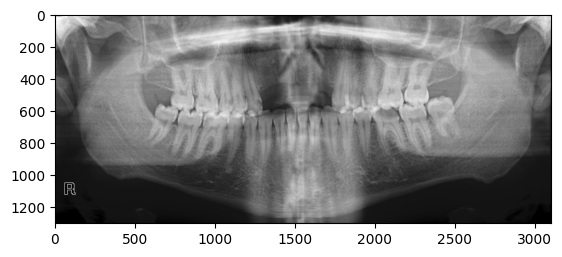

In [4]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

In [6]:
data = tf.keras.utils.image_dataset_from_directory('data', image_size=(350,350), batch_size=32)
data

Found 100 files belonging to 2 classes.


<BatchDataset element_spec=(TensorSpec(shape=(None, 350, 350, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [7]:
data_iterator = data.as_numpy_iterator()

In [8]:
#if run again will get another batch from the iterator
batch = data_iterator.next()

In [9]:
len(batch)

2

In [10]:
#images represented as numpy arrays
batch[0].shape

(32, 350, 350, 3)

In [10]:
#class 1 = periodontal
#class 0 = non periodontal
batch[1]

array([0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 0, 1, 0, 1, 1])

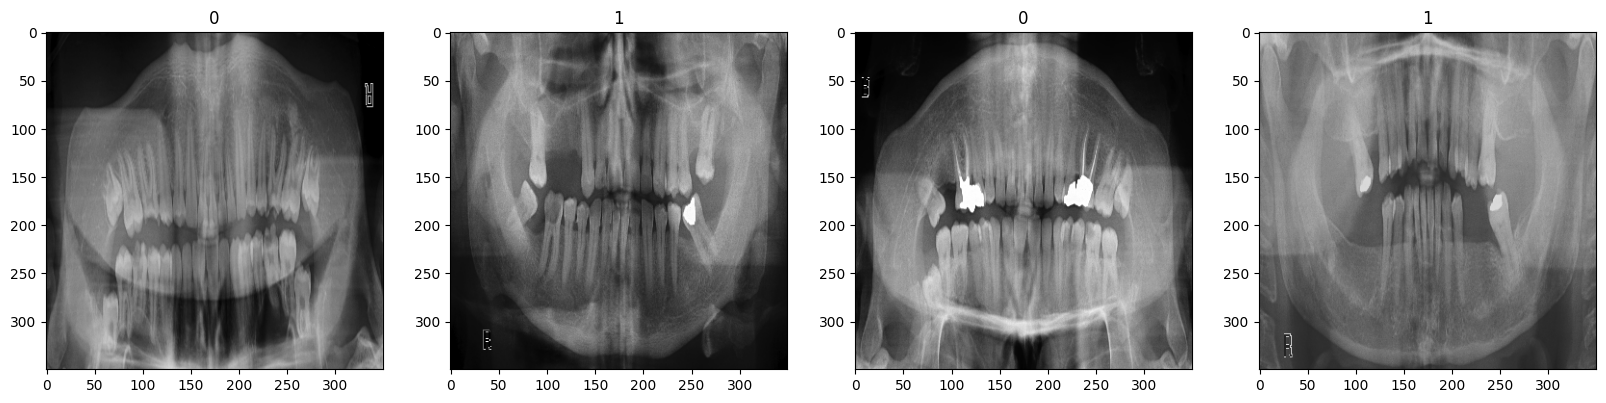

In [11]:
fig, ax = plt.subplots(ncols = 4, figsize =(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])
plt.show()

In [12]:
scaled = batch[0] / 255

In [13]:
scaled.max()

1.0

## Preprocess the Data

In [14]:
scaled_data = data.map(lambda x, y: (x/255, y))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [15]:
scaled_iterator = scaled_data.as_numpy_iterator()

In [16]:
batch = scaled_iterator.next()

In [17]:
batch[0].min()

0.0

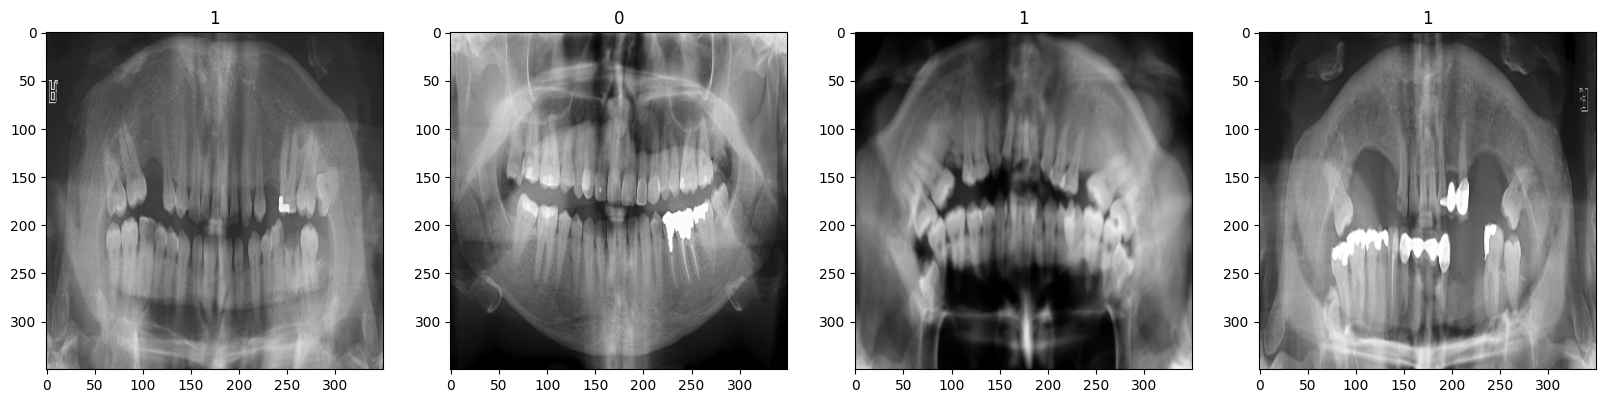

In [18]:
fig, ax = plt.subplots(ncols = 4, figsize =(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])
plt.show()

### split data

In [18]:
len(scaled_data)

4

In [19]:
#train 70%, validation 20%, test 10%
train_size = int(len(scaled_data)*.7)
val_size = int(len(scaled_data)*.2)+1
test_size = int(len(scaled_data)*.1)+1
train_size + val_size + test_size

4

In [20]:
train_size

2

In [21]:
train = scaled_data.take(train_size)
val = scaled_data.skip(train_size).take(val_size)
test = scaled_data.skip(train_size).skip(val_size).take(test_size)

## Deep Model

### build deep learning model

In [23]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [24]:
model = Sequential()

In [25]:
model.add(Conv2D(8,(3,3),1, activation = 'relu', input_shape = (350,350,3)))
model.add(MaxPooling2D())

model.add(Conv2D(16,(3,3),1, activation = 'relu'))
model.add(MaxPooling2D())

model.add(Conv2D(8,(3,3), 1, activation= 'relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation = 'sigmoid'))

In [26]:
model.compile('adam', loss = tf.losses.BinaryCrossentropy(), metrics = ['accuracy'])

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 348, 348, 8)       224       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 174, 174, 8)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 172, 172, 16)      1168      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 86, 86, 16)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 84, 84, 8)         1160      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 42, 42, 8)        0

## train

### train the model

In [28]:
logdir = 'logs'

In [29]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logdir)

In [30]:
hist = model.fit(train, epochs=10, validation_data= val, callbacks= [tensorboard_callback])

Epoch 1/10
26/26 [==============================] - 39s 1s/step - loss: 0.6904 - accuracy: 0.6010 - val_loss: 0.6354 - val_accuracy: 0.5391
Epoch 2/10
26/26 [==============================] - 38s 1s/step - loss: 0.5068 - accuracy: 0.7728 - val_loss: 0.3768 - val_accuracy: 0.8242
Epoch 3/10
26/26 [==============================] - 39s 1s/step - loss: 0.3319 - accuracy: 0.8630 - val_loss: 0.2471 - val_accuracy: 0.9492
Epoch 4/10
26/26 [==============================] - 38s 1s/step - loss: 0.2379 - accuracy: 0.9026 - val_loss: 0.1899 - val_accuracy: 0.9492
Epoch 5/10
26/26 [==============================] - 38s 1s/step - loss: 0.1384 - accuracy: 0.9531 - val_loss: 0.0906 - val_accuracy: 0.9570
Epoch 6/10
26/26 [==============================] - 38s 1s/step - loss: 0.1194 - accuracy: 0.9579 - val_loss: 0.1342 - val_accuracy: 0.9570
Epoch 7/10
26/26 [==============================] - 38s 1s/step - loss: 0.0578 - accuracy: 0.9880 - val_loss: 0.0454 - val_accuracy: 0.9883
Epoch 8/10
26/26 [==

In [31]:
hist.history

{'loss': [0.6903595328330994,
  0.5068331360816956,
  0.33189985156059265,
  0.23787346482276917,
  0.13840867578983307,
  0.11941087245941162,
  0.057783372700214386,
  0.02954413741827011,
  0.02875426597893238,
  0.011338570155203342],
 'accuracy': [0.6009615659713745,
  0.7728365659713745,
  0.8629807829856873,
  0.9026442170143127,
  0.953125,
  0.957932710647583,
  0.9879807829856873,
  0.9939903616905212,
  0.9939903616905212,
  0.9975961446762085],
 'val_loss': [0.635408341884613,
  0.37676703929901123,
  0.2470947653055191,
  0.18987084925174713,
  0.09064861387014389,
  0.13416750729084015,
  0.04537476599216461,
  0.06464887410402298,
  0.025385577231645584,
  0.014320159330964088],
 'val_accuracy': [0.5390625,
  0.82421875,
  0.94921875,
  0.94921875,
  0.95703125,
  0.95703125,
  0.98828125,
  0.9765625,
  0.9921875,
  0.99609375]}

### Plot Performance

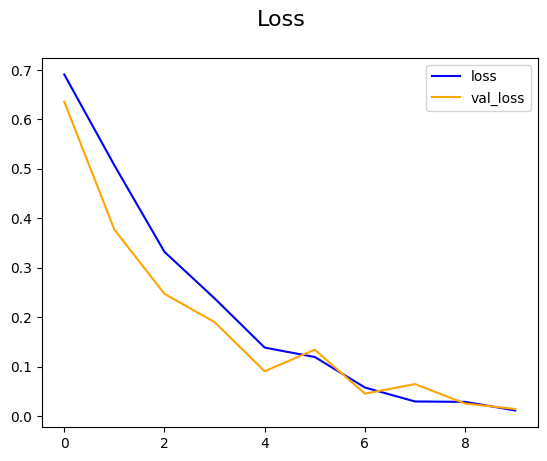

In [32]:
fig = plt.figure()
plt.plot(hist.history['loss'], color = 'blue', label = 'loss')
plt.plot(hist.history['val_loss'], color = 'orange', label = 'val_loss')
fig.suptitle('Loss', fontsize = 16)
plt.legend(loc = 'upper right')
plt.show()

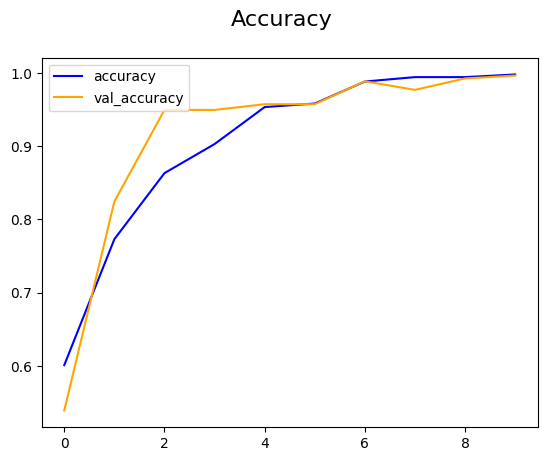

In [33]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color = 'blue', label = 'accuracy')
plt.plot(hist.history['val_accuracy'], color = 'orange', label = 'val_accuracy')
fig.suptitle('Accuracy', fontsize = 16)
plt.legend(loc = 'upper left')
plt.show()

## evaluate

### evaluate the model

In [34]:
from keras.metrics import Precision, Recall, BinaryAccuracy

In [35]:
pre = Precision()
re = Recall()
Bacc = BinaryAccuracy()


In [36]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    Bacc.update_state(y, yhat)
    #Acc.update_state(y,yhat)

1/1 [==============================] - 0s 171ms/step


In [37]:
print(f'Precision:{pre.result().numpy()}, Recall:{re.result().numpy()}, BAccuracy:{Bacc.result().numpy()}')

Precision:0.9830508232116699, Recall:0.9830508232116699, BAccuracy:0.9821428656578064


### test

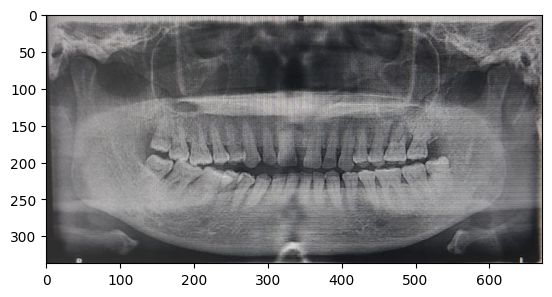

In [38]:
img = cv2.imread('peritest2.png')
imgC = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(imgC)
plt.show()

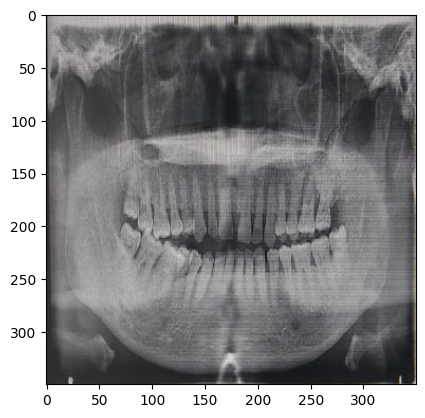

In [39]:
resize = tf.image.resize(imgC, (350,350))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [40]:
yhat = model.predict(np.expand_dims(resize/255,0))

1/1 [==============================] - 0s 29ms/step


In [41]:
yhat

array([[0.9980162]], dtype=float32)

In [42]:
if yhat > 0.5:
    print("Predicted class is Periodontitis")
else:
    print("Predicted class is NON Periodontitis")

Predicted class is Periodontitis


## save the model

### save model

In [2]:
from keras.models import load_model

In [18]:
model.save(os.path.join('models', 'ClassificationPeriodontitis10epd2.h5'))

In [22]:
model = load_model('models/ClassificationPeriodontitis10epd2Lpara.h5')

In [23]:
data = tf.keras.utils.image_dataset_from_directory('data2', image_size=(350,350), batch_size=32)
scaled_data = data.map(lambda x, y: (x/255, y))
scaled_iterator = scaled_data.as_numpy_iterator()
batch = scaled_iterator.next()
#train 70%, validation 20%, test 10%
train_size = int(len(scaled_data)*.7)
val_size = int(len(scaled_data)*.2)+1
test_size = int(len(scaled_data)*.1)+1
train_size + val_size + test_size
train = scaled_data.take(train_size)
val = scaled_data.skip(train_size).take(val_size)
test = scaled_data.skip(train_size).skip(val_size).take(test_size)

Found 1200 files belonging to 2 classes.


In [6]:
from keras.metrics import Precision, Recall, BinaryAccuracy

In [7]:
pre = Precision()
re = Recall()
Bacc = BinaryAccuracy()

In [24]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    Bacc.update_state(y, yhat)

print(f'Precision:{pre.result().numpy()}, Recall:{re.result().numpy()}, BAccuracy:{Bacc.result().numpy()}')

1/1 [==============================] - 0s 171ms/step
Precision:0.9824561476707458, Recall:0.9696969985961914, BAccuracy:0.9758771657943726
